In [11]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from common.utils import load_sql_to_df, plot_history
from datasets import MoveAsTensorDataset
import board_representation as br

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from common.training import train_loop, test_model

import random

import chess
import chess.engine
from stockfish import Stockfish

In [12]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [13]:
classified_moves = load_sql_to_df("SELECT position, move, sentiment FROM classified_moves", "../../chess.db")
classified_moves

,position,move,sentiment
0,2kr1b1r/ppp2ppp/2n5/4pb2/2P5/P1NP1PqP/1P4P1/R1...,e1d2,1
1,r1b3k1/5p1r/p7/q1n1Q2p/2p1P1p1/6P1/PP2N1BP/R4R...,c8b7,1
2,r1b2r2/p2n3k/1p4pp/2pp4/3P2Q1/P3P3/5PPP/2R3KR ...,d4c5,1
3,r2q4/2p2k2/P1p2pp1/2P5/3p3R/6Q1/P4PPK/8 b - - ...,f7g7,1
4,r1bqkbnr/p1p2ppp/3p4/2p1p3/2P1P3/5N2/PP1P1PPP/...,d2d3,1
...,...,...,...
301341,4r3/6kp/3p2p1/2q1p1b1/8/5BP1/Q4PKP/1R6 b - - 8 36,e5e4,0
301342,rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBN...,g1f3,0
301343,r1bq1rk1/ppp3pp/2np1n2/5p2/2PPpN2/2P1P3/P4PPP/...,h2h4,0
301344,3r1qk1/1p1n2p1/r1p2p1p/p2Pp3/P1P1P3/3Q1P2/5BPP...,c6c5,1


In [14]:
train_df, test_df = train_test_split(classified_moves, test_size=0.05, random_state=0)
display(train_df)
display(test_df)

,position,move,sentiment
61204,rnr5/pp2kp1p/6p1/2pn4/8/5B2/PP3PPP/R3K1NR b KQ...,d5b4,1
109043,r1b4r/pp1nb1pp/2pqk3/3np3/2B1QPP1/2N5/PPPP3P/R...,d7b6,0
195558,rn1qk1nr/5ppp/p3p3/1p1p1b2/3P4/RQP1PN2/1P3PPP/...,b8d7,0
265986,r2q1rk1/pb1nbppp/1pp2n2/3p4/1P1P4/P1N1PN2/3BBP...,f6e4,1
101672,r2qk2r/ppp2ppp/8/3p4/P3pP1P/R1Nnn1PN/1P1R2B1/6...,g2e4,0
...,...,...,...
211543,rn3r1k/p3qpp1/1p2p3/7n/2P5/P2BBb2/1Q3PPP/R3K2R...,g2f3,1
86293,5rk1/pp2q1p1/2p4p/3p4/3P4/3QP3/PP1R1rPP/2K4R w...,h2h4,0
122579,2r1qb2/pbp1n1k1/1p1pQnp1/1N6/2PP4/P2B1N2/1P3PP...,f3g5,0
152315,3qnrkb/Q6p/1r1p2p1/2pPp3/P1b5/2N1BP2/4N1PP/R4R...,b6b2,1


,position,move,sentiment
128629,r3kbnr/pp2ppp1/8/1q1pP2p/3p4/NP3Q1P/P1PB1PP1/R...,b5c6,0
29934,r1b1r1k1/1p4pp/p1p5/q2p4/8/3Q1P1P/3N2P1/3B1RK1...,a5c5,1
114423,2r3k1/1b2q1p1/p4p1p/Pp3P2/2pPpR2/4R2P/1PQ3P1/6...,c8e8,0
288897,1k1r3r/1bq1bpp1/pp6/2p1pP1n/3PP1Qp/2PB4/PB4PP/...,d4d5,0
292536,2r1b1k1/4n3/5r2/1p3pN1/3Rp3/2p1P3/1P3PP1/2KB3R...,d1b3,1
...,...,...,...
143554,1r2k2r/1pq1nppp/p2p1b2/2pBp3/4P3/P1NP1N1P/1PP2...,f1e1,0
133708,r1b2rk1/1pp2pbp/4p1p1/p2nP3/P2q4/1B3N1P/1PP1QP...,d4c5,0
94750,r2qk3/1n1b4/ppp1p1pr/4P1pp/1PQ5/7P/P1B2PP1/3R1...,g5g4,0
66730,rnbqkbnr/ppp1pppp/8/3P4/8/8/PPPP1PPP/RNBQKBNR ...,d8d5,1


In [15]:
train_dataset = MoveAsTensorDataset(train_df)
test_dataset = MoveAsTensorDataset(test_df)

In [16]:
class SentimateNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(26, 13, 5, padding='same'),
            nn.Dropout(0.25),
            nn.Conv2d(13, 26, 3, padding='same'),
            nn.Flatten()
        )

        self.fc_layers = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(8*8*26, 200),
            nn.ELU(),
            nn.Dropout(0.25),
            nn.Linear(200, 100),
            nn.ELU(),
            nn.Dropout(0.25),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [17]:
model = SentimateNet()
model = model.to(device)
model

SentimateNet(
  (conv_layers): Sequential(
    (0): Conv2d(26, 13, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Dropout(p=0.25, inplace=False)
    (2): Conv2d(13, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=1664, out_features=200, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
train_loader = DataLoader(train_dataset, batch_size=4096)
test_loader = DataLoader(test_dataset, batch_size=4096)

In [20]:
test_model(train_loader, model)
test_model(test_loader, model)

Test Error: Accuracy: 46.06%, Avg loss: 0.694949
Test Error: Accuracy: 45.79%, Avg loss: 0.695122


In [21]:
def join_lists(dict1, dict2):
    result_dict = {}
    for key in dict1.keys():
        result_dict[key] = dict1[key] + dict2[key]
    return result_dict

In [ ]:
history = train_loop(train_loader, model, val_dataloader=test_loader, num_epochs=200, optimizer=optimizer, verbose=True)

Epoch 1/200
Train loss: 0.689257, accuracy: 54.18%
Val loss:  0.686682, accuracy: 55.06%
-----------------------------
Epoch 2/200
Train loss: 0.687275, accuracy: 54.69%
Val loss:  0.686111, accuracy: 55.02%
-----------------------------
Epoch 3/200
Train loss: 0.686714, accuracy: 54.94%
Val loss:  0.686243, accuracy: 55.02%
-----------------------------
Epoch 4/200
Train loss: 0.686400, accuracy: 55.05%
Val loss:  0.686222, accuracy: 55.00%
-----------------------------
Epoch 5/200
Train loss: 0.686303, accuracy: 55.04%
Val loss:  0.685929, accuracy: 55.12%
-----------------------------
Epoch 6/200
Train loss: 0.685923, accuracy: 55.11%
Val loss:  0.685753, accuracy: 55.06%
-----------------------------
Epoch 7/200
Train loss: 0.685732, accuracy: 55.22%
Val loss:  0.685572, accuracy: 55.17%
-----------------------------
Epoch 8/200
Train loss: 0.685305, accuracy: 55.25%
Val loss:  0.685342, accuracy: 55.22%
-----------------------------

Loading best params on validation set (epoch 8,

Test Error: Accuracy: 58.05%, Avg loss: 0.684526


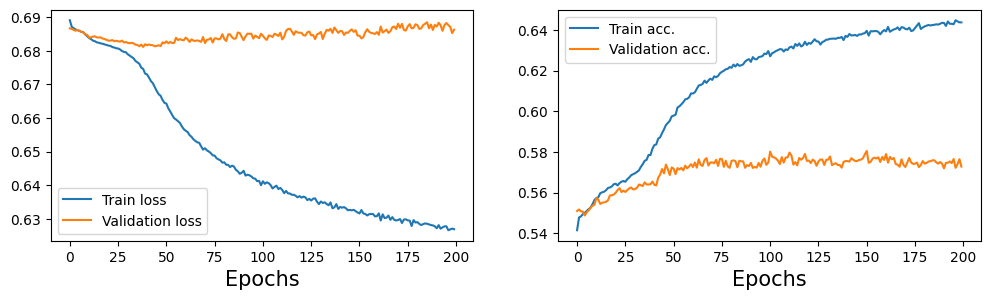

In [ ]:
test_model(test_loader, model)
plot_history(history)

In [ ]:
model

SentimateNet(
  (conv_layers): Sequential(
    (0): Conv2d(26, 13, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Dropout(p=0.25, inplace=False)
    (2): Conv2d(13, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=1664, out_features=200, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [ ]:
torch.save(model, "../../models/Sentimate_bad.model")
# model.load_state_dict(torch.load("../../models/Sentimate_bad.model"))

In [22]:
model = torch.load("../../models/Sentimate_bad.model")
model

SentimateNet(
  (conv_layers): Sequential(
    (0): Conv2d(26, 13, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Dropout(p=0.25, inplace=False)
    (2): Conv2d(13, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=1664, out_features=200, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [23]:
test_model(train_loader, model)
test_model(test_loader, model)

Test Error: Accuracy: 69.13%, Avg loss: 0.594383
Test Error: Accuracy: 58.04%, Avg loss: 0.684526


In [24]:
from collections import Counter

engine = chess.engine.SimpleEngine.popen_uci("stockfish")

def batch_legal_moves(board: chess.Board):
    move_tensors = [br.move_to_tensor(board.fen(), move) for move in board.legal_moves]
    return torch.stack(move_tensors)

def model_best_move(board: chess.Board, model: nn.Module):
    batch_moves = batch_legal_moves(board).to(device)
    batch_moves = batch_moves.to(device)

    model.eval()
    with torch.inference_mode():
        out = model(batch_moves)
        best_move_ind = out.argmax().item()
        best_move = list(board.legal_moves)[best_move_ind]

        return best_move
    

def compare_moves(board, move1, move2):
    result1 = engine.analyse(board, chess.engine.Limit(time=0.2), root_moves=[move1])
    result2 = engine.analyse(board, chess.engine.Limit(time=0.2), root_moves=[move2])
    
    if result1["score"].relative > result2["score"].relative:
        return -1
    elif result1["score"].relative < result2["score"].relative:
        return 1
    else:
        return 0
    
def compare_model_to_random_agent(model: nn.Module, fens, random_moves_from_position = 1):
    results = []
    for fen in fens:
        board = chess.Board(fen)

        legal_moves = list(board.legal_moves)

        model_move = model_best_move(board, model)

        for _ in range(random_moves_from_position):
            random_move = random.choice(legal_moves)
            comparison = compare_moves(board, model_move, random_move)
            results.append(comparison)

    stats = Counter(results)

    return {"model_better": stats[-1], "random_better": stats[1], "draw": stats[0]}

In [25]:
pos_to_test = list(test_df.position.sample(n = 500, random_state=0))
compare_model_to_random_agent(model, pos_to_test)

{'model_better': 276, 'random_better': 217, 'draw': 7}

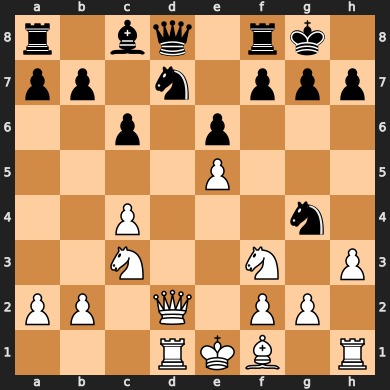

-1

In [26]:
board = chess.Board("r1bq1rk1/pp1n1ppp/2p1p3/4P3/2P3n1/2N2N1P/PP1Q1PP1/3RKB1R b K - 0 11")
display(board)
best_move = model_best_move(board, model)
random_move = random.choice(list(board.legal_moves))
compare_moves(board, best_move, random_move)

g8h8
<class 'chess.Move'>


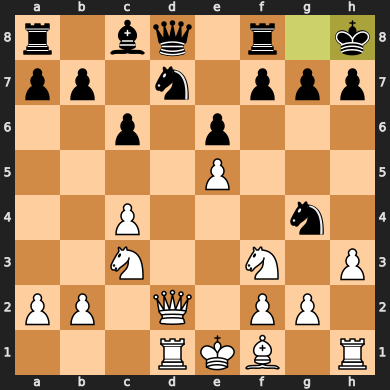

In [27]:
move = next(iter(board.legal_moves))
print(move)
print(type(move))

board.push(move)
board

In [34]:
class Agent:
    def __init__(self) -> None:
        pass

    def play(self, board: chess.Board):
        pass

class ModelAgent(Agent):
    def __init__(self, model) -> None:
        super().__init__()
        self.model = model
        self.model_device = next(iter(model.parameters())).device

    def batch_legal_moves(self, board: chess.Board):
        move_tensors = [br.move_to_tensor(board.fen(), move) for move in board.legal_moves]
        return torch.stack(move_tensors)

    def play(self, board: chess.Board):
        legal_moves = list(board.legal_moves)

        if len(legal_moves) == 0:
            return None
        
        batch_moves = self.batch_legal_moves(board).to(self.model_device)

        model.eval()
        with torch.inference_mode():
            out = model(batch_moves)
            best_move_ind = out.argmax().item()
            best_move = list(board.legal_moves)[best_move_ind]

            return best_move
        
class RandomAgent(Agent):
    def __init__(self) -> None:
        super().__init__()

    def play(self, board: chess.Board):
        legal_moves = list(board.legal_moves)

        if len(legal_moves) == 0:
            return None

        random_move = random.choice(legal_moves)

        return random_move

In [35]:
random_agent = RandomAgent()
model_agent = ModelAgent(model)

In [60]:
def play_game(white: Agent, black: Agent, n_moves = 40):
    board = chess.Board()

    # display(board)

    for i in range(n_moves):
        for agent in [white, black]:
            move = agent.play(board)

            if move == None:
                break

            board.push(move)

    return board

def simple_result(board, time = 1):
    score = engine.analyse(board, chess.engine.Limit(time=time))['score'].white()

    if score <= chess.engine.Cp(-10):
        return -1
    elif score < chess.engine.Cp(10):
        return 0
    return 1

In [61]:
def test_agent(model_agent, n_games = 50, n_moves = 40, time = 1):
    random_agent = RandomAgent()
    results = []    

    for game in range(n_games//2):
        final_board = play_game(model_agent, random_agent, n_moves=40)
        score = simple_result(final_board, time=time)
        results.append(score)

    for game in range(n_games//2):
        final_board = play_game(random_agent, model_agent, n_moves=40)
        score = -simple_result(final_board, time=time)
        results.append(score)

    stats = Counter(results)

    return {"model_better": stats[1], "random_better": stats[-1], "draw": stats[0]}


In [63]:
test_agent(model_agent, n_games=100)    

{'model_better': 68, 'random_better': 30, 'draw': 2}